# Проект. Selfie Segmentation

**Введение**

Selfie Segmentation -  выделения портретного изображения человека на картинке. Используется в задачи наложения фона в видео конференции. Модели, основанные на нейронных сетях, на первом этапе получают маску изображения - матрицу с размерами входного изображения, в которой записаны значения от 0 до 1. Чем больше значения элементов матриц тем вероятнее в этом месте находится портретное изображение человека. Далее на основе этой матрицы реальный фон на картинке заменяется на другое изображение. Такие модели должны не только качественно рассчитывать маску, но и делать это максимально быстро на ограниченном в ресурсах устройстве. При видеоконференции обычно используется частота 15-30 кадров в секунду. Модель даже на мобильном устройстве не должна тратить слишком много времени для получения маски, чтобы можно было поддерживать приемлемую частоту кадров.

**Цель:** Подобрать лучшую модель для задачи наложения фона в видео конференции.

**Задачи:**
*   Выбрать метрики качества;
*   Выбрать модели для selfie segmentation;
*   Преобразовать датасет для входа в каждую модель;
*   Получить метрики качества для каждой модели;
*   Сделать сравнительный анализ метрик качества;
*   Сравнить время расчёта маски моделями;
*   Выбрать модель с наилучшими метриками качества и меньшим временем расчёта;
*   Сравнить полученное решение с имеющимися (Zoom, MS Teams и и.д.).

**Датасет:** https://www.kaggle.com/code/vbookshelf/selfie-segmenter-keras-and-u-net

**Выполнил:** Попов Виктор Борисович

### Подготовка данных

In [75]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
image_dir = 'dataset/clip_img'
mask_dir  = 'dataset/matting'
image_mask_list = []
try:
    for (subdir_image, dirs_image, files_image), (subdir_mask, dirs_mask, files_mask) in zip(os.walk(image_dir), os.walk(mask_dir)):
        for file_image, file_mask in zip(files_image, files_mask):
            image_mask_list.append([os.path.join(subdir_image, file_image), os.path.join(subdir_mask, file_mask)])
            if os.path.splitext(file_image)[0] != os.path.splitext(file_mask)[0]:
                print("Error: image name \"{}\" and mask name \"{}\" are different".format(image_mask_list[-1][0], image_mask_list[-1][1]))
                raise FileNotFoundError
except FileNotFoundError:
    pass

image_mask_df = pd.DataFrame(image_mask_list, columns=['image_path', 'mask_path'])
dataset_size = image_mask_df.shape[0]
print("Found {} image-mask pairs".format(dataset_size))
image_mask_df.head()

Found 34426 image-mask pairs


image_path  \
0  dataset/clip_img\1803151818\clip_00000000\1803...   
1  dataset/clip_img\1803151818\clip_00000000\1803...   
2  dataset/clip_img\1803151818\clip_00000000\1803...   
3  dataset/clip_img\1803151818\clip_00000000\1803...   
4  dataset/clip_img\1803151818\clip_00000000\1803...   

                                           mask_path  
0  dataset/matting\1803151818\matting_00000000\18...  
1  dataset/matting\1803151818\matting_00000000\18...  
2  dataset/matting\1803151818\matting_00000000\18...  
3  dataset/matting\1803151818\matting_00000000\18...  
4  dataset/matting\1803151818\matting_00000000\18...

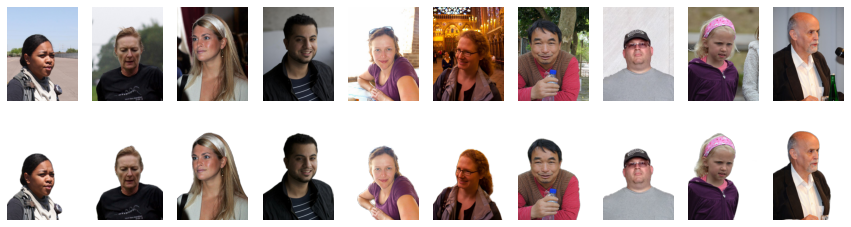

In [28]:
random.seed(0)
n = 10
fig, axs = plt.subplots(nrows=2, ncols=n, figsize=(15,4))
for i in range(n):
    image_mask_index = random.randrange(dataset_size)
    ax = axs[0, i]
    image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    ax.imshow(image)
    ax.axis('off')
    ax = axs[1, i]
    mask = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])
    ax.imshow(mask)
    ax.axis('off')

plt.show()

### Описание датасета
- 34426 RGB изображений людей в формате jpg - размер: (600, 800, 3)
- 34426 RGBA изображений людей без фона в формате png - размер: (600, 800, 4)

RGB изображения имеют 3 цветовых канала с целочисленными значениями в диапазоне [0; 225], RGBA изображения имеют 4 канала: 3 цветовых и 1 альфа (прозрачность пикселей) с вещественными значениями в диапазоне [0; 1]. 0 - это полностью прозрачный. 1 - это полностью видимый. 

Посмотрим как выглядит альфа канал, маска с порогом 0.5 и изображение с применением маски.

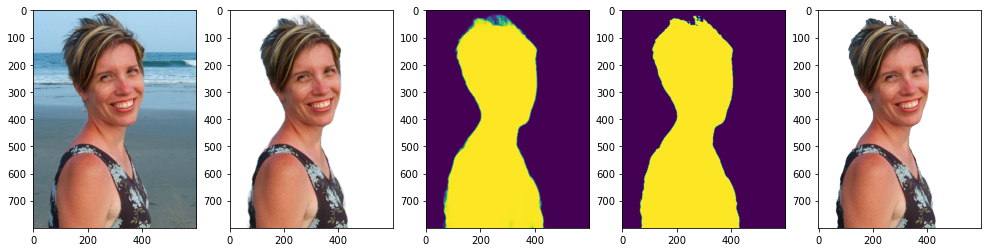

In [64]:
random.seed(3)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(17,4))

image_mask_index = random.randrange(dataset_size)

rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
rgba_image = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])

# выделим 4-ый канал
alpha = rgba_image[:,:,3]
# выделем маску на уровне 0.5 и переведём её в диапазон 0-255
mask = (alpha > 0.5).astype(np.uint8) * 255
# выделим объект на изображении при помощи маски
segmented_selfie =  np.dstack((rgb_image, mask))

axs[0].imshow(rgb_image)
axs[1].imshow(rgba_image)
axs[2].imshow(alpha)
axs[3].imshow(mask)
axs[4].imshow(segmented_selfie)

plt.show()

### Метрики качества

#### Пересечение над объединением (IoU - Intersection over Union)
***IoU*** используется для определения качества моделей нахождения (Object Detection) и выделения (Segmentation) объектов на изображении. Этот параметр оценивает перекрытие реальной области нахождения объекта и предсказанной маски.

<img src="img/Understanding-Intersection-Over-Union-in-Object-Detection-and-Segmentation.webp">

Для вычисления ***IoU*** используется попиксельный анализ представленный ниже. Площадь области в данном случае вычисляется сложением пикселей, находяжихся в данной области.  

***True Positive:*** Площадь пересечения реальной области (Ground Truth - GT) и предсказанной маски (Segmentation - S). Математически выражается логической операцией ***И*** между ***GT*** и ***S***: <img src="img/True-Positive.png" width="120">
<br>
***False Positive:*** Площадь предсказанной маски, которая не пересекается с реально областью. Это можно выразить логическим ***ИЛИ*** между ***GT*** и ***S*** минус ***GT***: <img src="img/False-Positive.webp" width="200">
<br>
***False Negative:*** Площадь внутри реальной области, которую не верно предсказала модель. Это можно выразить логическим ***ИЛИ*** между ***GT*** и ***S*** минус ***S***:<img src="img/False-Negative.png" width="180">
<br>
***IoU*** выражается как отношение площади пересечения реальной области с объектом и предсказанной маски к объединённой площади:
<img src="img/Intersection-over-Union-IoU-in-Object-Detection-and-Segmentation-formula.webp" width="220">
<br>
Иллюстрация ***TP***, ***FP*** и ***FN***:
<img src="img/5-segmentation-iou.webp">

Для оценки качества работы модели воспользуемся средним значением ***IoT*** по всему датасету - ***mIoT***.

Подробнее о ***IoT***: https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/


#### Время расчёта маски
Для задачи наложения виртуального фона важным показателем является время расчёта маски сегментации на различных устройствах, в том числе мобильных. Во время видеоконференций расчёт маски будет происходить на устройстве. Это может быть персональный компьютер или смартфон. Стандартная частота кадров в видео конференциях 30 кадров в секунду. Соответственно для обеспечения такой частоты кадров время расчёта маски не должно превышать 33 милисекунд. Приемлимой может быть частота кадров 15 кадров в секунду и максимальное время расчёта менее 66 мс. В худшем случае 7,5 кадров в секунду и максимальное время расчёта 132 мс. При дольшем расчёте видео не будет приемлимого качества и общаться будет не удобно.
Время расчёта маски будет вычисляться на достаточно мощном ПК HP ZBook Power G7 с процессором Intel(R) Core(TM) i7-10750H 2.60GHz. 

# Модели
* Пример запуска https://github.com/Innovation4x/SelfieSeg https://github.com/anilsathyan7/Portrait-Segmentation
* mediapipe: https://colab.research.google.com/drive/1LwpblseHAIEPn8Ow5J-TbBUq0zgV60PV?usp=sharing
* demo: https://github.com/Volcomix/virtual-background

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [193]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import ipywidgets as widgets
import threading
from keras.models import load_model
import mediapipe as mp
import tensorflow as tf
from models.SINet import *
from torchvision import transforms
from sklearn.metrics import jaccard_score # То же самое, что и IoU
import time

In [4]:
def merge_with_background(rgb_image, mask, rgb_background):
    fg = cv2.bitwise_or(rgb_image, rgb_image, mask=mask)
    bg = cv2.bitwise_or(rgb_background, rgb_background, mask=~mask)
    out = cv2.bitwise_or(fg, bg)
    return out

In [320]:
def get_true_mask(image_mask_index):
    rgba_image = plt.imread(image_mask_df.iloc[image_mask_index]['mask_path'])
    # выделим 4-ый канал
    alpha = rgba_image[:,:,3]
    # выделем маску на уровне 0.5 и переведём её в диапазон 0-255
    return (alpha > 0.5).astype(np.uint8) * 255

In [536]:
def calc_pred_mask(model, image_mask_index):
    image = cv2.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    
    start_time = time.time()
    mask = model.seg(image)
    calc_time = (time.time() - start_time) * 1000
        
    return (mask > 127).astype(np.uint8) * 255, calc_time

In [409]:
def show_example(model):
    random.seed(7)
    n = 10
    fig, axs = plt.subplots(nrows=3, ncols=n, figsize=(18,6))
    bgd = cv2.imread('./img/background.jpg')
    bgd = cv2.cvtColor(bgd, cv2.COLOR_BGR2RGB)
    bgd = cv2.resize(bgd, (600, 800))
    
    row_titles = ["Оригинал", "Правильная сегментация", "Сегментация модели {}".format(model.short_name())]
    for ax, row_title in zip(axs[:,0], row_titles):
        ax.annotate(row_title, xy=(0, 0.5), xytext=(0, 0.5), xycoords='axes fraction', textcoords='axes fraction',
                    size='large', ha='right', va='center')
    for i in range(n):
        image_mask_index = random.randrange(dataset_size)

        ax = axs[0, i]
        rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
        ax.imshow(rgb_image)
        ax.axis('off')

        ax = axs[1, i]
        true_mask = get_true_mask(image_mask_index)
        segmented_selfie_true = merge_with_background(rgb_image, true_mask, bgd)
        ax.imshow(segmented_selfie_true)
        ax.axis('off')

        ax = axs[2, i]
        pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
        segmented_selfie_pred = merge_with_background(rgb_image, pred_mask, bgd)
        ax.imshow(segmented_selfie_pred)
        ax.axis('off')    

        print("IoU {:.2f}".format(jaccard_score(true_mask, pred_mask, average="micro")))
        print("Time of segmentation {:.0f} milliseconds".format(calc_time))
        
    fig.tight_layout()
    plt.show()

### MobileNet version 2

In [236]:
class SelfieSegMNV2:
    def __init__(self):
        # Initialize tflite-interpreter
        self.interpreter = tf.lite.Interpreter(model_path="models/deconv_fin_munet.tflite")
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape'][1:3]

        # Image overlay
        self.overlay = np.zeros((self.input_shape[0], self.input_shape[1], 3), np.uint8)
        self.overlay[:] = (127, 0, 0)

    def short_name(self):
        return "MNV2"
    
    def seg(self, frame):
        # BGR->RGB, CV2->PIL
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(rgb)

        width = image.width
        height = image.height
        
        # Resize image
        image = image.resize(self.input_shape, Image.ANTIALIAS)

        # Normalization
        image = np.asarray(image)
        prepimg = image / 255.0
        prepimg = prepimg[np.newaxis, :, :, :]

        # Segmentation
        self.interpreter.set_tensor(self.input_details[0]['index'], np.array(prepimg, dtype=np.float32))
        self.interpreter.invoke()
        outputs = self.interpreter.get_tensor(self.output_details[0]['index'])

        # Process the output
        output = np.uint8(outputs[0] > 0.5)
        res = np.reshape(output, self.input_shape)
        mask = Image.fromarray(np.uint8(res), mode="P")
        mask = np.array(mask.convert("RGB")) * self.overlay
        mask = cv2.resize(np.asarray(mask), (width, height), interpolation=cv2.INTER_CUBIC)
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_CUBIC)

        return mask

In [237]:
segMNV2 = SelfieSegMNV2()

IoU 0.99
Time of segmentation 48 milliseconds
IoU 0.98
Time of segmentation 46 milliseconds
IoU 0.97
Time of segmentation 48 milliseconds
IoU 0.97
Time of segmentation 50 milliseconds
IoU 0.97
Time of segmentation 48 milliseconds
IoU 0.93
Time of segmentation 47 milliseconds
IoU 0.96
Time of segmentation 47 milliseconds
IoU 0.98
Time of segmentation 49 milliseconds
IoU 0.88
Time of segmentation 57 milliseconds
IoU 0.96
Time of segmentation 47 milliseconds


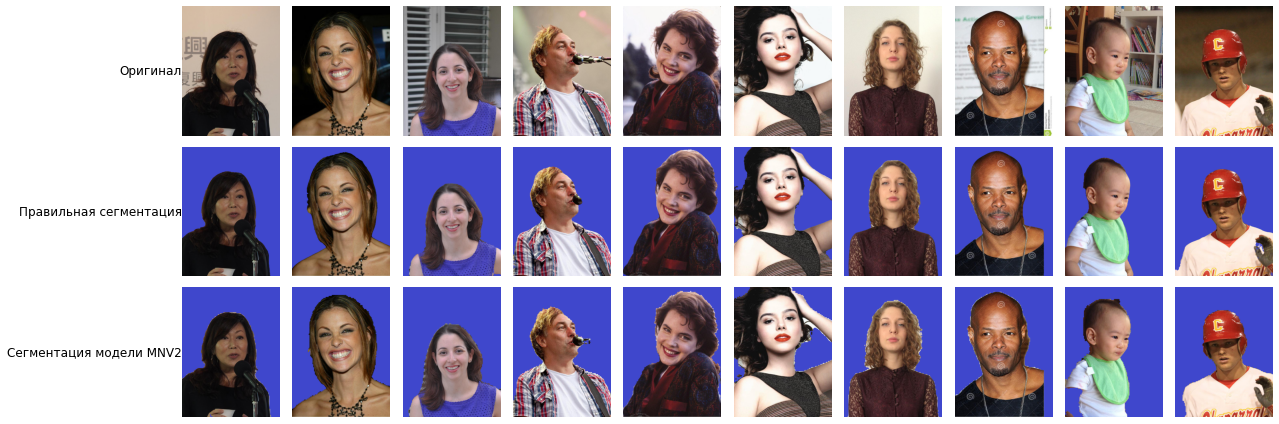

In [561]:
show_example(segMNV2)    

### MobileNet version 3

In [284]:
class SelfieSegMNV3:
    def __init__(self):
        self.dim = 224
        self.model = load_model("models/munet_mnv3_wm10.h5")

    def short_name(self):
        return "MNV3"

    def seg(self, rgb_image):
        image = Image.fromarray(rgb_image)
        
        width = image.width
        height = image.height

        image = image.resize((self.dim, self.dim), Image.ANTIALIAS)
        img = np.float32(np.array(image) / 255.0)
        img = img[:, :, 0:3]

        # Reshape input and threshold output
        out = self.model.predict(img.reshape(1, self.dim, self.dim, 3), verbose=0)
        
        out = np.float32((out > 0.5)).reshape(self.dim, self.dim)
        mask = (255 * out).astype("uint8")

        mask = cv2.resize(mask, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [285]:
segMNV3 = SelfieSegMNV3()

IoU 0.98
Time of segmentation 493 milliseconds
IoU 0.97
Time of segmentation 272 milliseconds
IoU 0.90
Time of segmentation 262 milliseconds
IoU 0.96
Time of segmentation 261 milliseconds
IoU 0.93
Time of segmentation 275 milliseconds
IoU 0.80
Time of segmentation 263 milliseconds
IoU 0.94
Time of segmentation 264 milliseconds
IoU 0.97
Time of segmentation 259 milliseconds
IoU 0.58
Time of segmentation 263 milliseconds
IoU 0.98
Time of segmentation 252 milliseconds


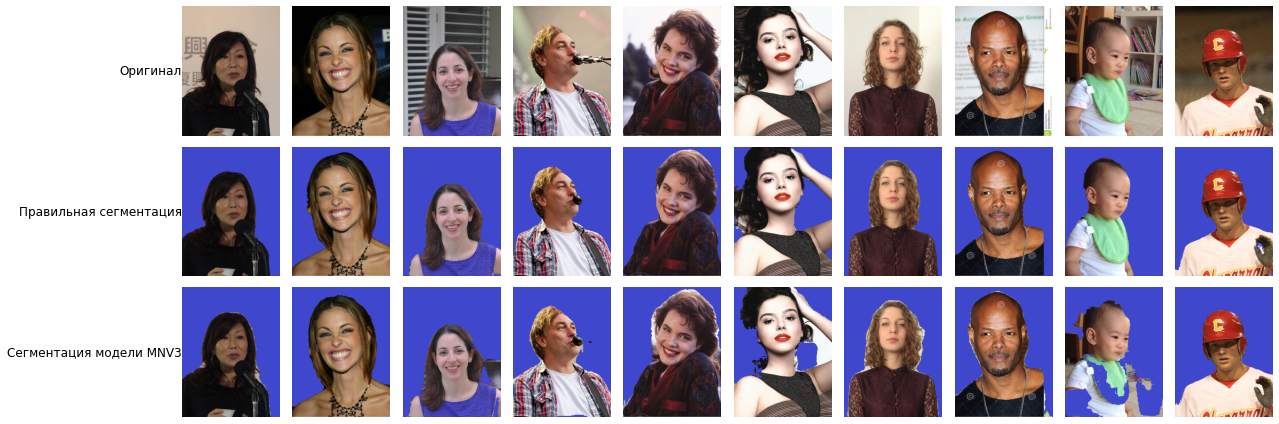

In [541]:
show_example(segMNV3)    

### PortraitNet

In [334]:
class SelfieSegPN:
    def __init__(self, with_prev = False):
        self.interpreter = tf.lite.Interpreter(model_path="models/portrait_video.tflite")  # Use 'tf.lite' on recent tf versions
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        h, w = self.input_details[0]['shape'][1:3]
        self.dim = w
        self.with_prev = with_prev
        self.prev = np.zeros((self.dim, self.dim, 1))

    def short_name(self):
        return "PN"

    def normalize(self, imgOri, scale=1, mean=[103.94, 116.78, 123.68], val=[0.017, 0.017, 0.017]):
        img = np.array(imgOri.copy(), np.float32) / scale
        return (img - mean) * val

    def seg(self, frame):
        img = np.array(frame)
        
        width = img.shape[1]
        height = img.shape[0]
        
        img = cv2.resize(img, (self.dim, self.dim))
        img = img.astype(np.float32)

        img = self.normalize(img)

        # Add prior as fourth channel
        img = np.dstack([img, self.prev])
        img = img[np.newaxis, :, :, :]

        # Invoke interpreter for inference
        self.interpreter.set_tensor(self.input_details[0]['index'], np.array(img, dtype=np.float32))
        self.interpreter.invoke()
        out = self.interpreter.get_tensor(self.output_details[0]['index'])
        out = out.reshape(self.dim, self.dim, 1)
        out = (255 * out).astype("uint8")
        _, out = cv2.threshold(out, 128, 255, cv2.THRESH_BINARY)
        
        if self.with_prev:
            self.prev = (out / 255.0).astype("float32")

        mask = cv2.resize(out, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [335]:
segPN = SelfieSegPN()

IoU 0.99
Time of segmentation 42 milliseconds
IoU 0.97
Time of segmentation 38 milliseconds
IoU 0.98
Time of segmentation 37 milliseconds
IoU 0.97
Time of segmentation 46 milliseconds
IoU 0.97
Time of segmentation 42 milliseconds
IoU 0.96
Time of segmentation 39 milliseconds
IoU 0.96
Time of segmentation 40 milliseconds
IoU 0.94
Time of segmentation 40 milliseconds
IoU 0.97
Time of segmentation 45 milliseconds
IoU 0.97
Time of segmentation 46 milliseconds


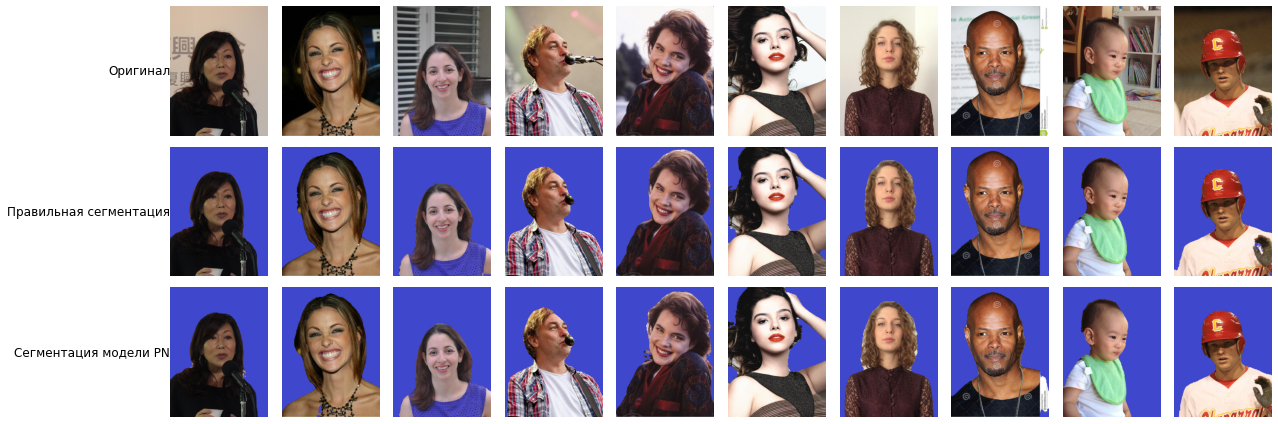

In [562]:
show_example(segPN)    

### SINet

In [242]:
class SelfieSegSN:
    def __init__(self):
        # Load the sinet pytorch model
        self.config = [[[3, 1], [5, 1]], [[3, 1], [3, 1]],
                  [[3, 1], [5, 1]], [[3, 1], [3, 1]], [[5, 1], [3, 2]], [[5, 2], [3, 4]],
                  [[3, 1], [3, 1]], [[5, 1], [5, 1]], [[3, 2], [3, 4]], [[3, 1], [5, 2]]]
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.model = SINet(classes=2, p=2, q=8, config=self.config, chnn=1)
        self.model.load_state_dict(torch.load('./models/model_296.pth', map_location=self.device))
        self.model.eval()

        # Enable gpu mode, if cuda available
        self.model.to(self.device)

        # Mean and std. deviation for normalization
        self.mean = [102.890434, 111.25247, 126.91212]
        self.std = [62.93292, 62.82138, 66.355705]
        self.dim = 320

    def short_name(self):
        return "SN"

    def seg(self, frame):
        img = np.array(frame)
        
        width = img.shape[1]
        height = img.shape[0]
        
        img = cv2.resize(img, (self.dim, self.dim))
        img = img.astype(np.float32)

        # Normalize and add batch dimension
        img = (img - self.mean) / self.std
        img /= 255
        img = img.transpose((2, 0, 1))
        img = img[np.newaxis, ...]

        # Load the inputs into GPU
        inps = torch.from_numpy(img).float().to(self.device)

        # Perform prediction and plot results
        with torch.no_grad():
            torch_res = self.model(inps)
            _, mask = torch.max(torch_res, 1)

        # Alpha blending with background image
        mask = mask.view(self.dim, self.dim, 1).cpu().numpy()
        mask = mask * 255
        mask = mask.reshape(self.dim, self.dim).astype("uint8")
        mask = cv2.resize(mask, (width, height))
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [243]:
segSN = SelfieSegSN()

SB Net Enc bracnch num :  2
SB Net Enc chnn num:  1
SINet Enc bracnch num :  2
SINet Enc chnn num:  1
This module has [[3, 1], [5, 1]]
This module has [[3, 1], [3, 1]]
This module has [[3, 1], [5, 1]]
This module has [[3, 1], [3, 1]]
This module has [[5, 1], [3, 2]]
This module has [[5, 2], [3, 4]]
This module has [[3, 1], [3, 1]]
This module has [[5, 1], [5, 1]]
This module has [[3, 2], [3, 4]]
This module has [[3, 1], [5, 2]]


IoU 0.99
Time of segmentation 451 milliseconds
IoU 0.98
Time of segmentation 455 milliseconds
IoU 0.98
Time of segmentation 423 milliseconds
IoU 0.98
Time of segmentation 432 milliseconds
IoU 0.98
Time of segmentation 442 milliseconds
IoU 0.89
Time of segmentation 452 milliseconds
IoU 0.98
Time of segmentation 445 milliseconds
IoU 0.98
Time of segmentation 430 milliseconds
IoU 0.98
Time of segmentation 438 milliseconds
IoU 0.98
Time of segmentation 485 milliseconds


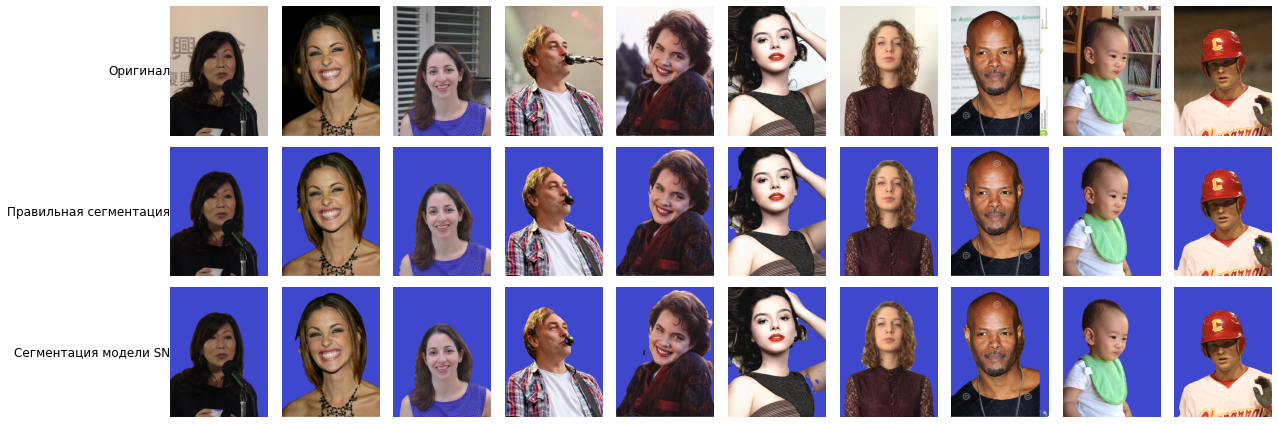

In [543]:
show_example(segSN)    

### DeepLabV3 models with ResNet-101 backbones 

In [244]:
class SelfieSegDLV3:
    def __init__(self):
        self.dev = "cpu"
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
        self.model.eval()

    def short_name(self):
        return "DLV3"

    def seg(self, frame):
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # Comment the Resize and CenterCrop for better inference results
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(img)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        with torch.no_grad():
            output = self.model(input_batch)['out'][0]
        output_predictions = output.argmax(0)

        colors = np.array([(0, 0, 0),  # 0=background
             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (255, 255, 255),
             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)])

        # plot the semantic segmentation predictions of 21 classes in each color
        out = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(img.size)
        out.putpalette(colors)
        out = np.array(out)

        mask = (255 * (out / 15)).astype("uint8")  # 15=person
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [265]:
segDLV3 = SelfieSegDLV3()

Using cache found in C:\Users\qoowe/.cache\torch\hub\pytorch_vision_v0.10.0


IoU 0.98
Time of segmentation 5033 milliseconds
IoU 0.96
Time of segmentation 4357 milliseconds
IoU 0.96
Time of segmentation 4477 milliseconds
IoU 0.97
Time of segmentation 4246 milliseconds
IoU 0.94
Time of segmentation 4408 milliseconds
IoU 0.92
Time of segmentation 4615 milliseconds
IoU 0.96
Time of segmentation 4451 milliseconds
IoU 0.97
Time of segmentation 4283 milliseconds
IoU 0.81
Time of segmentation 4417 milliseconds
IoU 0.96
Time of segmentation 4459 milliseconds


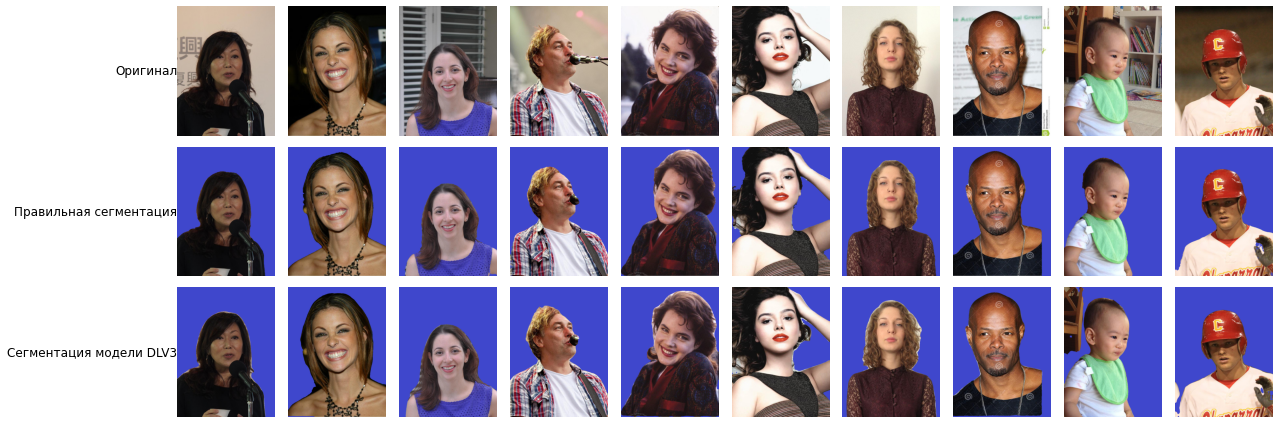

In [544]:
show_example(segDLV3)    

### Fully-Convolutional Network model with ResNet-101 backbones.

In [262]:
class SelfieSegFCN:
    def __init__(self):
        self.dev = "cpu"
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
        self.model.eval()

    def short_name(self):
        return "FCN"

    def seg(self, frame):
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Comment the Resize and CenterCrop for better inference results
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        input_tensor = preprocess(img)
        input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model

        with torch.no_grad():
            output = self.model(input_batch)['out'][0]
        output_predictions = output.argmax(0)

        colors = np.array([(0, 0, 0),  # 0=background
             # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
             # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0),
             # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (255, 255, 255),
             # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
             (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0)])

        # plot the semantic segmentation predictions of 21 classes in each color
        out = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(img.size)
        out.putpalette(colors)
        out = np.array(out)

        mask = (255 * (out / 15)).astype("uint8")  # 15=person
        _, mask = cv2.threshold(mask, 128, 255, 0)

        return mask

In [263]:
segFCN = SelfieSegFCN()

Using cache found in C:\Users\qoowe/.cache\torch\hub\pytorch_vision_v0.10.0


IoU 0.98
Time of segmentation 4190 milliseconds
IoU 0.95
Time of segmentation 3683 milliseconds
IoU 0.96
Time of segmentation 3963 milliseconds
IoU 0.96
Time of segmentation 3616 milliseconds
IoU 0.94
Time of segmentation 3702 milliseconds
IoU 0.91
Time of segmentation 3773 milliseconds
IoU 0.96
Time of segmentation 3672 milliseconds
IoU 0.98
Time of segmentation 3649 milliseconds
IoU 0.80
Time of segmentation 3675 milliseconds
IoU 0.97
Time of segmentation 3752 milliseconds


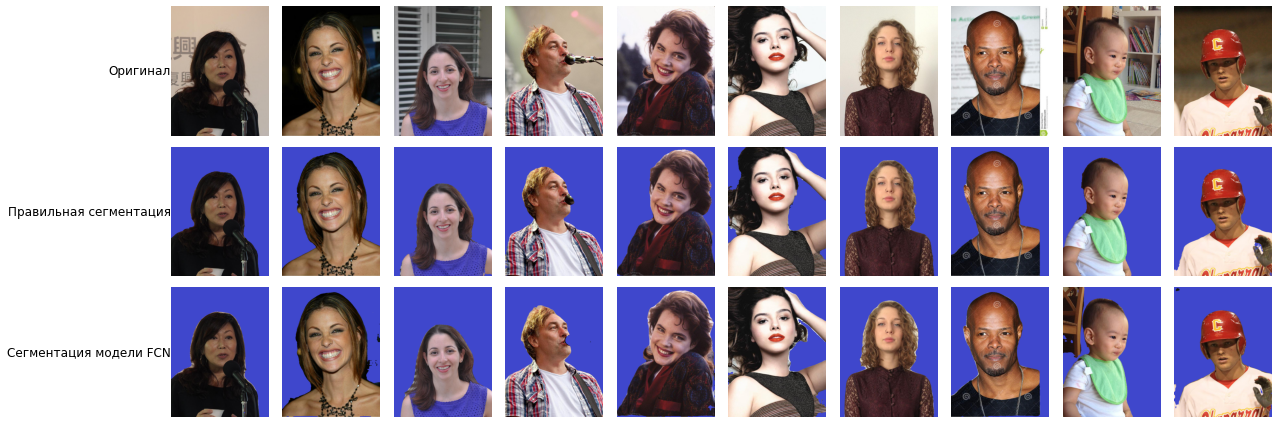

In [545]:
show_example(segFCN)    

### Mediapipe

In [553]:
class SelfieSegMP:
    def __init__(self):
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_selfie_segmentation = mp.solutions.selfie_segmentation
        self.selfie_segmentation = self.mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

    def short_name(self):
        return "MP"

    def seg(self, frame):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = self.selfie_segmentation.process(image)

        mask = cv2.resize(results.segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
        mask = (255 * mask).astype("uint8")
        _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

        return mask

In [554]:
segMP = SelfieSegMP()

IoU 0.99
Time of segmentation 15 milliseconds
IoU 0.98
Time of segmentation 14 milliseconds
IoU 0.97
Time of segmentation 14 milliseconds
IoU 0.96
Time of segmentation 15 milliseconds
IoU 0.93
Time of segmentation 15 milliseconds
IoU 0.87
Time of segmentation 14 milliseconds
IoU 0.96
Time of segmentation 13 milliseconds
IoU 0.95
Time of segmentation 14 milliseconds
IoU 0.97
Time of segmentation 14 milliseconds
IoU 0.98
Time of segmentation 14 milliseconds


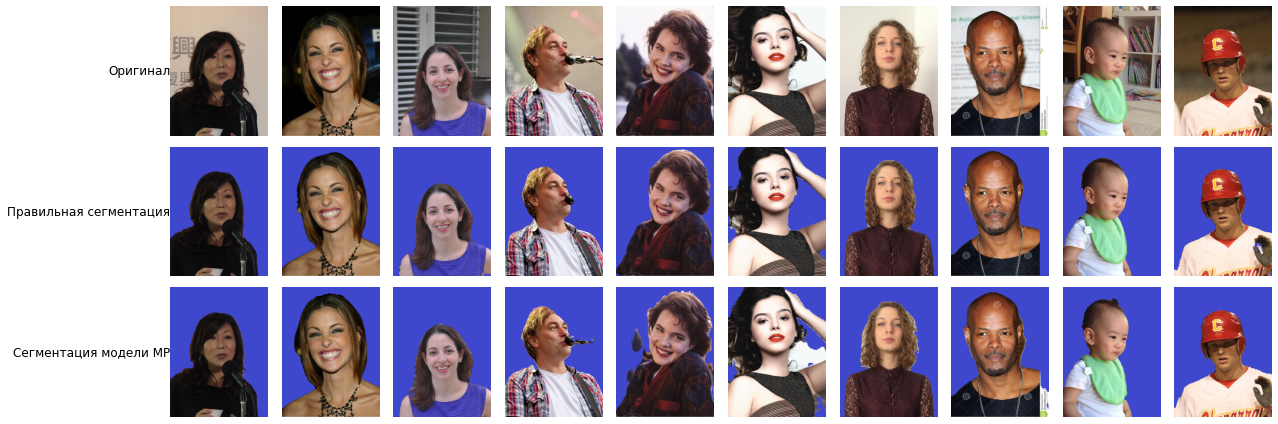

In [563]:
show_example(segMP)    

Модели MobileNet version 3, SINet и модели на основе ResNet-101 тратят на расчёт маски неприемлимо долгое время (более 300 миллисекунд), которое не позволит обеспечить даже скорость 7,5 кадров в секунду. Этого не достаточно для видео в реальном времени, поэтому эти модели будут исключены из дальнейшего исследования.

In [557]:
models = [segMNV2, segPN, segMP]

# Подготовка к оценке моделей

In [122]:
a = np.array([[0, 0, 0],
     [0, 255, 0],
     [0, 255, 0]])
b = np.array([[0, 0, 0],
     [0, 255, 0],
     [0, 255, 0]] )
jaccard_score(a, b, average="micro")

1.0

In [125]:
type(a)

numpy.ndarray

In [142]:
from sklearn.utils.multiclass import type_of_target

IoU 0.97
Time of segmentation 55 milliseconds


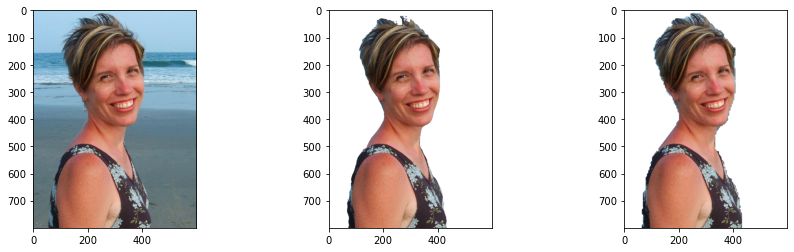

In [576]:
random.seed(3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

image_mask_index = random.randrange(dataset_size)

rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])

true_mask = get_true_mask(image_mask_index)
pred_mask, calc_time = calc_pred_mask(segMNV2, image_mask_index)

print("IoU {:.2f}".format(jaccard_score(true_mask, pred_mask, average="micro")))
print("Time of segmentation {:.0f} milliseconds".format(calc_time))

segmented_selfie_true =  np.dstack((rgb_image, true_mask))
segmented_selfie_pred =  np.dstack((rgb_image, pred_mask))

axs[0].imshow(rgb_image)
axs[1].imshow(segmented_selfie_true)
axs[2].imshow(segmented_selfie_pred)

plt.show()

In [200]:
def IoUAndTime(model, image_mask_index):
    true_mask = get_true_mask(image_mask_index)
    
    pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
    
    IoU = jaccard_score(true_mask, pred_mask, average="micro")
    
    return IoU, calc_time    

# Расчёт метрик качества

In [586]:
for model in models:
    IoU_list = []
    calc_time_list = []
    print(model.short_name())
    
    for index in range(len(image_mask_df)):
        if index % 1000 == 0:
            print("index = {}".format(index))
        if model.short_name() in ["PN", "MP"]:
            continue
        IoU, calc_time = IoUAndTime(model, index)
        IoU_list.append(IoU)
        calc_time_list.append(calc_time)
    
    if model.short_name() in ["PN", "MP"]:
        continue
    image_mask_df['{}_IoU'.format(model.short_name())] = IoU_list
    image_mask_df['{}_calc_time'.format(model.short_name())] = calc_time_list
    

MNV2
index = 0
index = 1000
index = 2000
index = 3000
index = 4000
index = 5000
index = 6000
index = 7000
index = 8000
index = 9000
index = 10000
index = 11000
index = 12000
index = 13000
index = 14000
index = 15000
index = 16000
index = 17000
index = 18000
index = 19000
index = 20000
index = 21000
index = 22000
index = 23000
index = 24000
index = 25000
index = 26000
index = 27000
index = 28000
index = 29000
index = 30000
index = 31000
index = 32000
index = 33000
index = 34000
PN
index = 0
index = 1000
index = 2000
index = 3000
index = 4000
index = 5000
index = 6000
index = 7000
index = 8000
index = 9000
index = 10000
index = 11000
index = 12000
index = 13000
index = 14000
index = 15000
index = 16000
index = 17000
index = 18000
index = 19000
index = 20000
index = 21000
index = 22000
index = 23000
index = 24000
index = 25000
index = 26000
index = 27000
index = 28000
index = 29000
index = 30000
index = 31000
index = 32000
index = 33000
index = 34000
MP
index = 0
index = 1000
index = 2000

In [ ]:
image_mask_df.head()

### Сравнение моделей

In [ ]:
def metric_statistic_table(metric):
    metric_statistic_df = pd.DataFrame(index=["$Mean$", "$Q_3 + 1.5 IQR$", "$Q_3$", "$Median$", "$Q_1$", "$Q_1 - 1.5 IQR$"])
    for model in models:
        model_metric_values = image_mask_df["{}_{}".format(model.short_name(), metric)]
        mean = model_metric_values.mean()
        Q1 = model_metric_values.quantile(0.25)
        Q3 = model_metric_values.quantile(0.75)
        low_whisker = Q1 - 1.5 * (Q)
        

In [492]:
image_mask_df['MNV2_IoU'].max()

0.9967271361029247

In [491]:
from matplotlib.cbook import boxplot_stats
boxplot_stats(image_mask_df['MNV2_IoU'])

[{'mean': 0.9535784457742815,
  'iqr': 0.033968426389449635,
  'cilo': 0.9699529891760708,
  'cihi': 0.97052784878382,
  'whishi': 0.9967271361029247,
  'whislo': 0.8961638614885838,
  'fliers': array([0.80861201, 0.85013228, 0.89367382, ..., 0.88473418, 0.84782837,
         0.76977547]),
  'q1': 0.9470571299863644,
  'med': 0.9702404189799454,
  'q3': 0.981025556375814}]

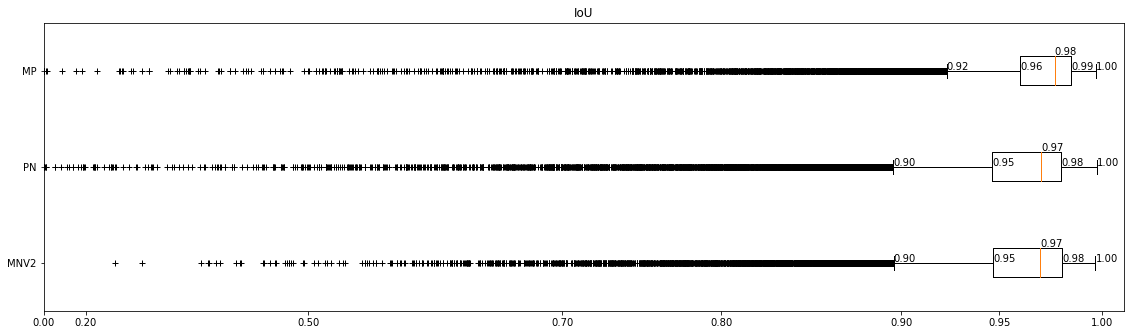

In [533]:
fig = plt.figure(figsize =(15, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
f = lambda a: a**2
g = lambda b: b**2
ax.set_xscale('function', functions=(f, g))
ax.set_xlim([0, 1.01])
ax.set_xticks([0,0.2,0.5,0.7,0.8,0.9,0.95,1])
ax.set_title("IoU")
bp = ax.boxplot(image_mask_df[['MNV2_IoU', 'PN_IoU', 'MP_IoU']], labels=['MNV2', 'PN', 'MP'], 
                sym = '+', vert=False,)
for line in bp['whiskers']:
    (x_l, y),(x_r, _) = line.get_xydata()
    ax.text(x_l, y+0.01, '%.2f' % x_l, fontsize=10)
    ax.text(x_r, y+0.01, '%.2f' % x_r, fontsize=10)
for line in bp['medians']:
    (x, y) = line.get_xydata()[1]
    ax.text(x, y+0.02, '%.2f' % x, fontsize=10)
plt.show()

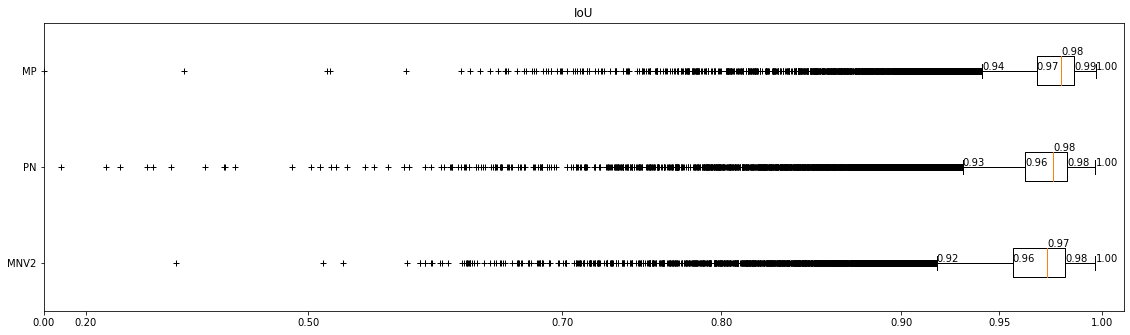

In [588]:
fig = plt.figure(figsize =(15, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
f = lambda a: a**2
g = lambda b: b**2
ax.set_xscale('function', functions=(f, g))
ax.set_xlim([0, 1.01])
ax.set_xticks([0,0.2,0.5,0.7,0.8,0.9,0.95,1])
ax.set_title("IoU")
bp = ax.boxplot(image_mask_df[['MNV2_IoU', 'PN_IoU', 'MP_IoU']], labels=['MNV2', 'PN', 'MP'], 
                sym = '+', vert=False,)
for line in bp['whiskers']:
    (x_l, y),(x_r, _) = line.get_xydata()
    ax.text(x_l, y+0.01, '%.2f' % x_l, fontsize=10)
    ax.text(x_r, y+0.01, '%.2f' % x_r, fontsize=10)
for line in bp['medians']:
    (x, y) = line.get_xydata()[1]
    ax.text(x, y+0.02, '%.2f' % x, fontsize=10)
plt.show()

In [529]:
bp['medians'][0].get_xydata()[1]

array([0.97024042, 1.15      ])

In [506]:
bp.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

In [587]:
print("IoU < 0.9")
print("MNV2: {:.0f} %".format(image_mask_df[(image_mask_df['MNV2_IoU']<0.9)].shape[0] / dataset_size * 100))
print("PN: {:.0f} %".format(image_mask_df[(image_mask_df['PN_IoU']<0.9)].shape[0] / dataset_size * 100))
print("MP: {:.0f} %".format(image_mask_df[(image_mask_df['MP_IoU']<0.9)].shape[0] / dataset_size * 100))

IoU < 0.9
MNV2: 5 %
PN: 5 %
MP: 3 %


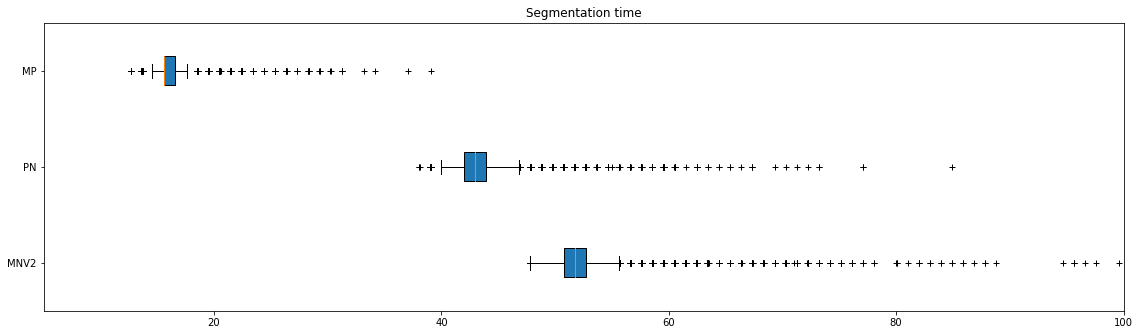

In [591]:
fig = plt.figure(figsize =(15, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
f = lambda a: a**2
g = lambda b: b**2
# ax.set_xscale('function', functions=(f, g))
ax.set_xlim([5, 100])
ax.set_title("Segmentation time")
bp = ax.boxplot(image_mask_df[['MNV2_calc_time', 'PN_calc_time', 'MP_calc_time']], labels=['MNV2', 'PN', 'MP'], 
                sym = '+', patch_artist=True, vert=False)
plt.show()

### Примеры худшей сегментации 

In [428]:
def show_all_models_example(image_mask_index):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,5))
    bgd = cv2.imread('./img/background.jpg')
    bgd = cv2.cvtColor(bgd, cv2.COLOR_BGR2RGB)
    bgd = cv2.resize(bgd, (600, 800))
    
    #row_titles = [, "Правильная сегментация", "Сегментация модели {}".format(model.short_name())]
    #for ax, row_title in zip(axs[:,0], row_titles):
    #    ax.annotate(row_title, xy=(0, 0.5), xytext=(0, 0.5), xycoords='axes fraction', textcoords='axes fraction',
    #                size='large', ha='right', va='center')
    ax = axs[0]
    ax.set_title("Оригинал")
    rgb_image = plt.imread(image_mask_df.iloc[image_mask_index]['image_path'])
    ax.imshow(rgb_image)
    ax.axis('off')
    
    ax = axs[1]
    ax.set_title("Правильная сегментация")
    true_mask = get_true_mask(image_mask_index)
    segmented_selfie_true = merge_with_background(rgb_image, true_mask, bgd)
    ax.imshow(segmented_selfie_true)
    ax.axis('off')
    
    for ax_col_index, model in zip(range(2, 5), models):
        ax = axs[ax_col_index]
        IoU = image_mask_df.iloc[image_mask_index]['{}_IoU'.format(model.short_name())]
        ax.set_title("{}, IoU={:.2f}".format(model.short_name(), IoU))
        pred_mask, calc_time = calc_pred_mask(model, image_mask_index)
        segmented_selfie_pred = merge_with_background(rgb_image, pred_mask, bgd)
        ax.imshow(segmented_selfie_pred)
        ax.axis('off')
        
    fig.tight_layout()
    plt.show()

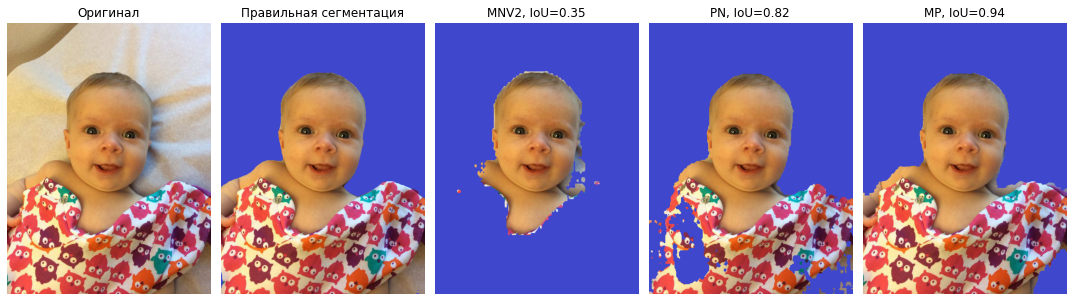

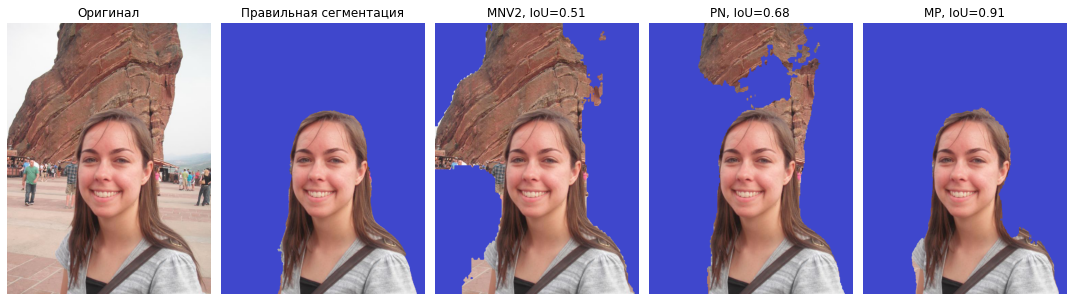

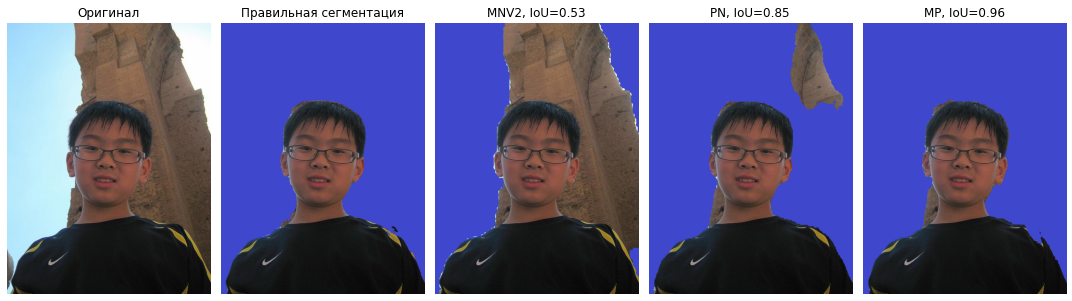

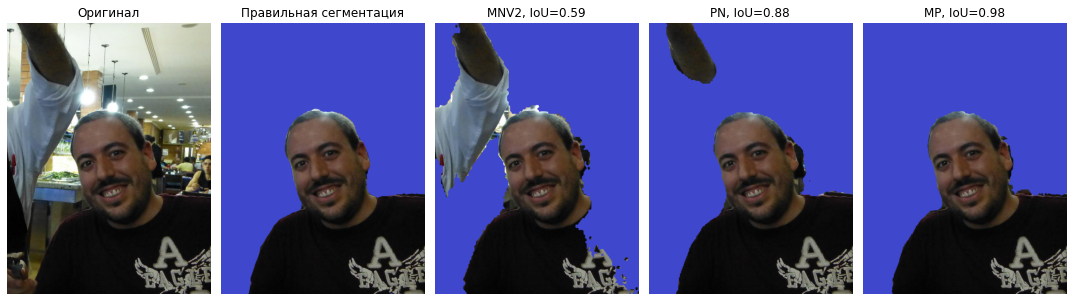

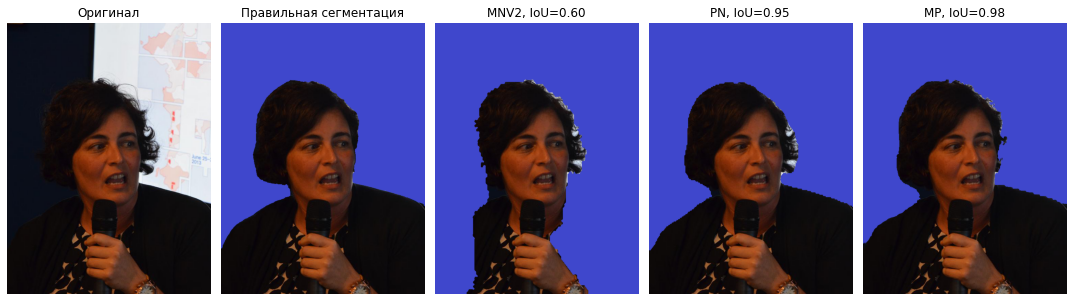

In [592]:
for index in image_mask_df.sort_values('MNV2_IoU').index[:5]:
    show_all_models_example(index)

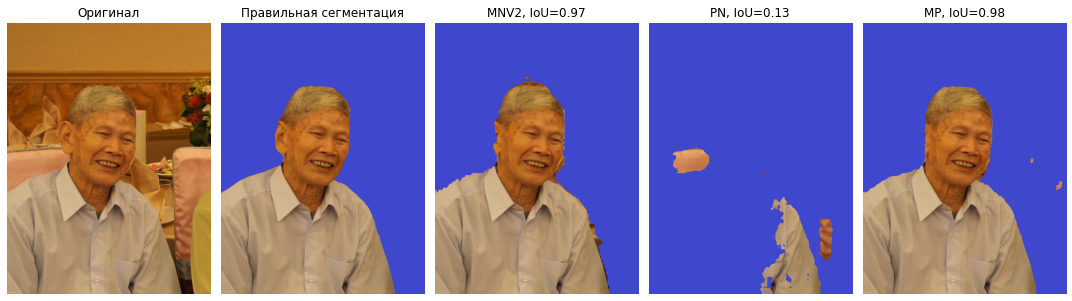

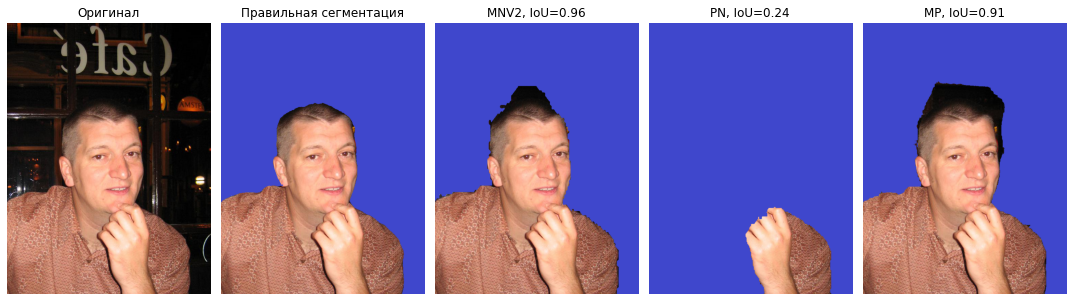

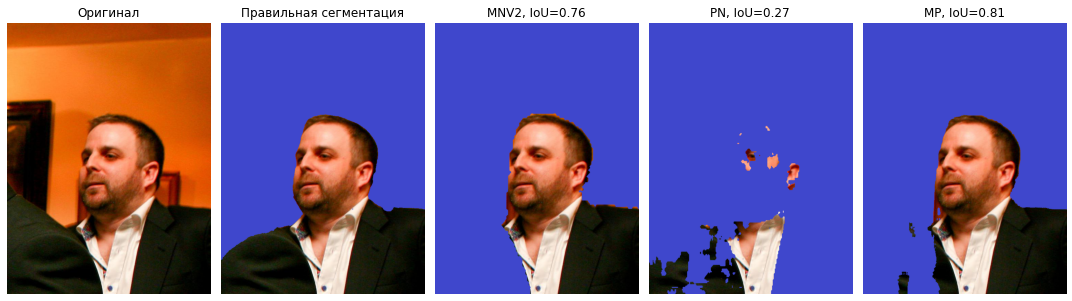

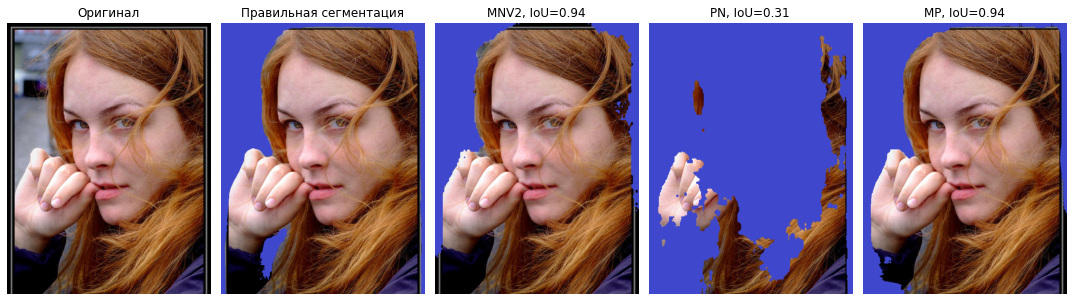

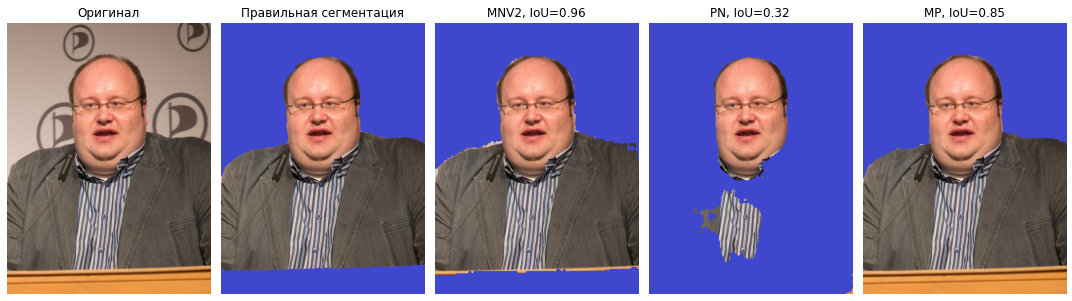

In [593]:
for index in image_mask_df.sort_values('PN_IoU').index[:5]:
    show_all_models_example(index)

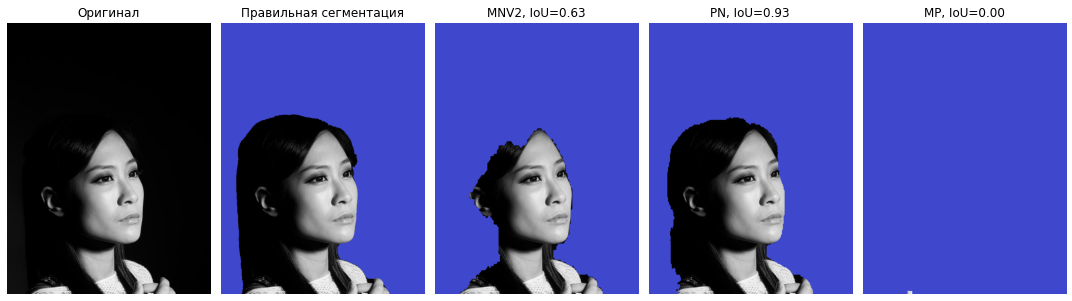

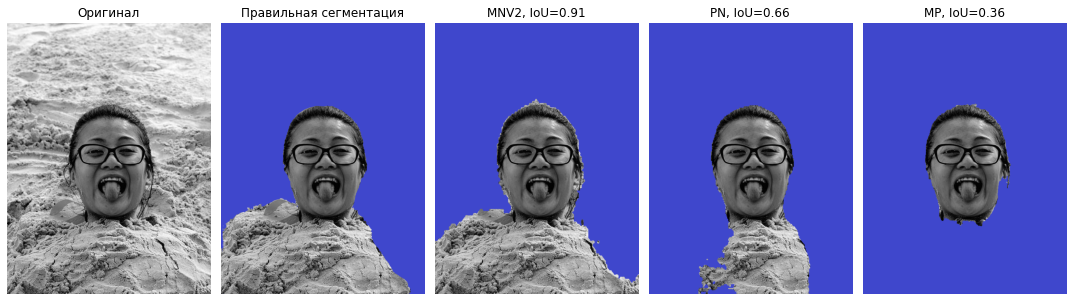

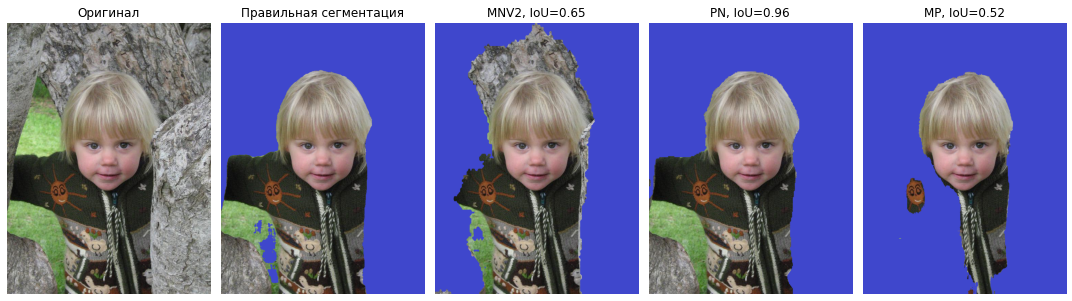

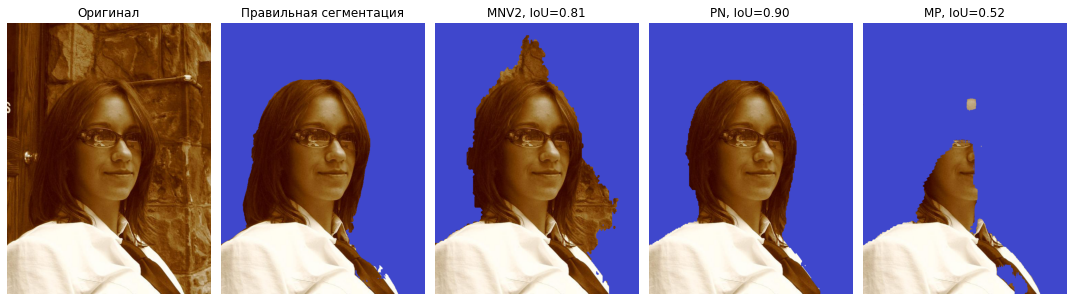

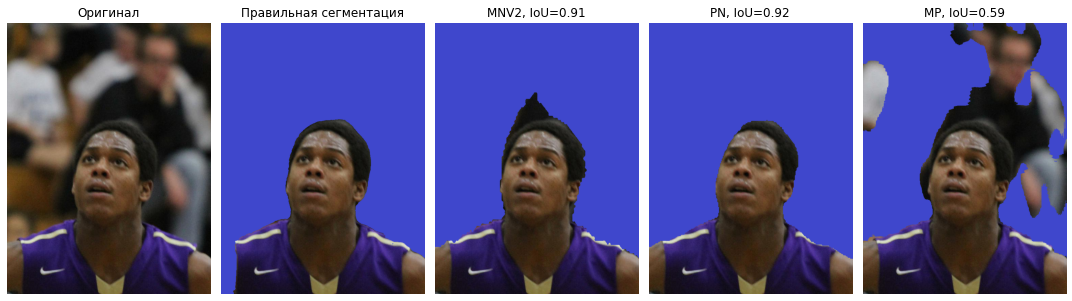

In [594]:
for index in image_mask_df.sort_values('MP_IoU').index[:5]:
    show_all_models_example(index)

### Камера

In [15]:
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)




In [19]:
import cv2, sys, time
import numpy as np
from keras.models import load_model
from PIL import Image


    
# Display function
# ================
def view(button):
    seg = SelfieSegMNV3(width, height)

    # Capture video from camera
    cap = cv2.VideoCapture(0)
    cap.set(3, width)
    cap.set(4, height)

    # Load and resize the background image
    bgd = cv2.imread('./img/background.jpg')
    bgd = cv2.resize(bgd, (width, height))

    elapsedTime = 0
    count = 0

    display_handle=display(None, display_id=True)
    while True:
        t1 = time.time()

        # Read input frames
        success, frame = cap.read()
        if not success:
            cap.release()
            break

        # Get segmentation mask
        mask = seg.seg(frame)


        elapsedTime += (time.time() - t1)
        count += 1
        fps = "{:.1f} FPS".format(count / elapsedTime)

        # Show output in window
        cv2.putText(out, fps, (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (38, 255, 38), 1, cv2.LINE_AA)
    #         cv2.imshow('Selfie Segmentation', out)
        display_handle.update(Image.fromarray(out))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)
    cap.release()
            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()


ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None

1/1 [==============================] - 0s 29ms/step
